In [1]:
import pulsar

seed = b'43'
model = pulsar.REPOS[1] # celebahq

alice_stego = pulsar.Pulsar(seed=seed, repo=model)

In [2]:
# Calculate the maximum message length that can be transmitted
m_len = alice_stego.estimate_regions(n_hist_bins=100, n_to_gen=1, end_to_end=True)
print(m_len)

100%|██████████| 50/50 [00:18<00:00,  2.74it/s]


571


In [3]:
# Generate a message to send
alice_message = b'E' * (m_len)

# Uncomment this for a random message instead
# import os
# alice_message = os.urandom(m_len)

alice_generate_results = alice_stego.generate_with_regions(alice_message)

100%|██████████| 50/50 [00:01<00:00, 45.31it/s]


In [4]:
last = alice_stego.scheduler.num_inference_steps - 1
alice_hidden_sample = alice_generate_results["samples"][last]["hidden"]

In [5]:
import PIL
import png # pypng package
import torch
import numpy as np

def display_sample(sample):
    image_processed = sample.cpu().permute(0, 2, 3, 1)
    image_processed = (image_processed + 1.0) * 127.5
    image_processed = image_processed.numpy().astype(np.uint8)

    image_pil = PIL.Image.fromarray(image_processed[0])

    display(image_pil)


def save_sample(sample, fname, dtype=np.uint16):
    image_processed = sample.cpu().permute(0, 2, 3, 1).numpy()
    dtype_max = np.iinfo(dtype).max

    y = image_processed[0]
    z = (y + 1.0) * (dtype_max/2)
    image_processed = z.astype(dtype)

    # https://stackoverflow.com/a/25814423
    with open(fname, "wb") as f:
        writer = png.Writer(width=image_processed.shape[1], height=image_processed.shape[0], bitdepth=int(np.log2(dtype_max))+1, greyscale=False)
        image2list = image_processed.reshape(-1, image_processed.shape[1]*image_processed.shape[2]).tolist()
        writer.write(f, image2list)

def load_sample(fname, device, dtype=np.uint16):
    with open(fname, "rb") as f:
        reader = png.Reader(f)
        png_data  = reader.asDirect()
        # https://pypng.readthedocs.io/en/latest/ex.html#png-to-numpy-array-reading
        image = np.vstack(list(map(dtype, png_data[2])))

    dtype_max = np.iinfo(dtype).max

    image = image.reshape((1, 256, 256, 3))
    image = image.astype(np.float32)
    image = torch.tensor(image)
    image = (image / (dtype_max/2)) - 1.0

    sample = image.permute(0, 3, 1, 2)
    sample = sample.to(device)
    return sample

In [6]:
fname = "/tmp/pulsar_alice.png"
alice_stego.save_sample(alice_hidden_sample, fname)
alice_hidden_sample

tensor([[[[ 0.2116,  0.2094,  0.2076,  ...,  0.4663,  0.4691,  0.4640],
          [ 0.2046,  0.1971,  0.1990,  ...,  0.4664,  0.4696,  0.4692],
          [ 0.1967,  0.1879,  0.1860,  ...,  0.4686,  0.4705,  0.4697],
          ...,
          [ 0.4931,  0.4952,  0.4982,  ...,  0.2540,  0.2962,  0.1974],
          [ 0.4900,  0.4970,  0.4964,  ...,  0.2649,  0.3267,  0.2048],
          [ 0.4847,  0.4950,  0.4975,  ...,  0.2685,  0.3422,  0.2126]],

         [[ 0.1317,  0.1284,  0.1309,  ...,  0.4854,  0.4854,  0.4800],
          [ 0.1276,  0.1200,  0.1240,  ...,  0.4868,  0.4852,  0.4826],
          [ 0.1163,  0.1152,  0.1141,  ...,  0.4906,  0.4892,  0.4860],
          ...,
          [ 0.5739,  0.5730,  0.5709,  ...,  0.0069,  0.0318, -0.0758],
          [ 0.5751,  0.5765,  0.5767,  ...,  0.0138,  0.0629, -0.0667],
          [ 0.5711,  0.5718,  0.5715,  ...,  0.0240,  0.0718, -0.0556]],

         [[-0.7388, -0.7506, -0.7568,  ...,  0.3618,  0.3596,  0.3596],
          [-0.7586, -0.7630, -

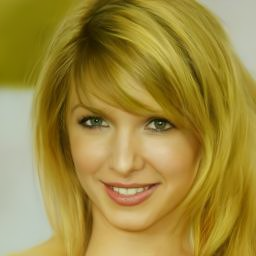

In [7]:
display_sample(alice_hidden_sample)

In [8]:
bob_stego = pulsar.Pulsar(seed=seed, repo=model)

In [9]:
# Load sample from saved sample
# Uncomment if using a different filename
# fname = "/tmp/pulsar_bob.png"
received_hidden_sample = bob_stego.load_sample(fname)
received_hidden_sample

tensor([[[[ 0.2115,  0.2094,  0.2076,  ...,  0.4662,  0.4690,  0.4640],
          [ 0.2046,  0.1971,  0.1990,  ...,  0.4664,  0.4696,  0.4692],
          [ 0.1966,  0.1879,  0.1860,  ...,  0.4686,  0.4705,  0.4697],
          ...,
          [ 0.4931,  0.4952,  0.4982,  ...,  0.2540,  0.2962,  0.1973],
          [ 0.4900,  0.4970,  0.4964,  ...,  0.2649,  0.3267,  0.2048],
          [ 0.4847,  0.4950,  0.4975,  ...,  0.2685,  0.3422,  0.2126]],

         [[ 0.1317,  0.1284,  0.1309,  ...,  0.4854,  0.4853,  0.4800],
          [ 0.1276,  0.1200,  0.1239,  ...,  0.4868,  0.4852,  0.4826],
          [ 0.1163,  0.1152,  0.1141,  ...,  0.4905,  0.4892,  0.4860],
          ...,
          [ 0.5739,  0.5730,  0.5709,  ...,  0.0069,  0.0318, -0.0758],
          [ 0.5750,  0.5764,  0.5766,  ...,  0.0138,  0.0629, -0.0667],
          [ 0.5711,  0.5718,  0.5714,  ...,  0.0240,  0.0718, -0.0556]],

         [[-0.7389, -0.7507, -0.7568,  ...,  0.3618,  0.3595,  0.3596],
          [-0.7586, -0.7630, -

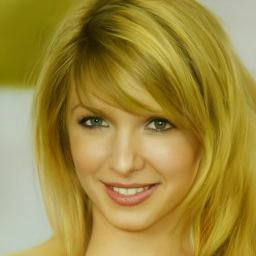

In [10]:
display_sample(received_hidden_sample)

In [11]:
# Sanity check
# Make sure Alice can decode before sending to Bob
alice_stego.reveal_with_regions(received_hidden_sample)


b'EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [12]:
# Offline phase
bob_stego.estimate_regions(n_hist_bins=100, n_to_gen=1, end_to_end=True)

100%|██████████| 50/50 [00:11<00:00,  4.19it/s]


571

In [13]:
# Online phase
bob_stego.reveal_with_regions(received_hidden_sample)

b'EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE'

In [14]:
alice_stego.benchmarks

{'__init__': [1723899776.313552, 1723899777.29432],
 'model_loading': [1723899776.313552, 1723899777.291942],
 'estimate_regions': [1723899777.301399, 1723899798.317388],
 'model_iterations': [1723899777.3025122, 1723899795.942864],
 'initial_model_iteration': [1723899777.302513, 1723899795.621703],
 'gen_variance_noise': [1723899792.369066, 1723899793.51795],
 'gen_variance_noise_1': [1723899793.638326, 1723899794.658537],
 'max_message_len': [571],
 'generate_with_regions': [1723899798.323321, 1723899802.559714],
 'sage_encode': [1723899798.325702, 1723899801.443294],
 'model_embed': [1723899801.4506721, 1723899802.5597131],
 'reveal_with_regions': [1723899805.166327, 1723899809.1434848],
 'model_de_embed': [1723899805.166328, 1723899805.1735868],
 'sage_decode': [1723899805.192816, 1723899809.143473]}

In [15]:
bob_stego.benchmarks

{'__init__': [1723899804.469621, 1723899805.089325],
 'model_loading': [1723899804.469621, 1723899805.086421],
 'estimate_regions': [1723899809.1494532, 1723899821.703269],
 'model_iterations': [1723899809.150898, 1723899821.289286],
 'initial_model_iteration': [1723899809.1509, 1723899821.113156],
 'gen_variance_noise': [1723899818.068738, 1723899819.1086679],
 'gen_variance_noise_1': [1723899819.223008, 1723899820.271241],
 'max_message_len': [571],
 'reveal_with_regions': [1723899821.708075, 1723899825.476319],
 'model_de_embed': [1723899821.708076, 1723899821.710111],
 'sage_decode': [1723899821.7295942, 1723899825.476309]}